# 从原始数据解析出events

In [1]:
import numpy as np
import mne

sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (sample_data_folder / 'MEG' / 'sample' /
                        'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)
raw.crop(tmax=60).load_data()

Opening raw data file /Users/DanDan/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 36037  =      0.000 ...    60.000 secs...


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.7 MB, data loaded>

In [ ]:
# both the Events and Annotations data structures serve the same purpose: 
# they provide a mapping between times during an EEG/MEG recording and a description of what happened at those times. 

# Units: the Events data structure represents the when in terms of samples, whereas the Annotations data structure represents the when in seconds.
# Limits on the description: the Events data structure represents the what as an integer “Event ID” code, whereas the Annotations data structure represents the what as a string.
# How duration is encoded: Events in an Event array do not have a duration (though it is possible to represent duration with pairs of onset/offset events within an Events array), whereas each element of an Annotations object necessarily includes a duration (though the duration can be zero if an instantaneous event is desired).
# Internal representation: Events are stored as an ordinary NumPy array, whereas Annotations is a list-like class defined in MNE-Python.

Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>


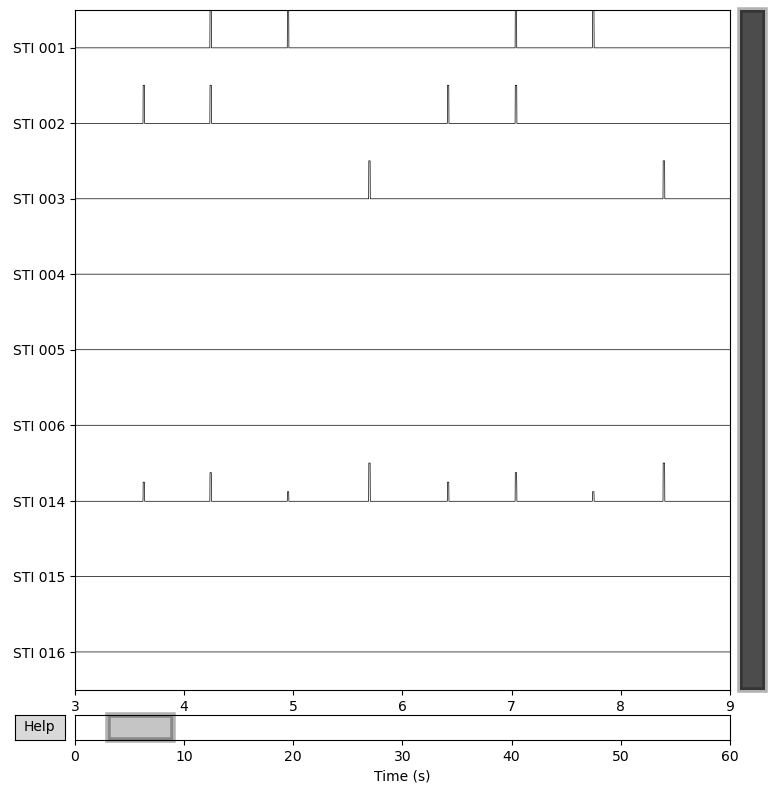

In [3]:
# A stim channel (short for “stimulus channel”) is a channel that does not receive signals from an EEG, MEG, or other sensor.
raw.copy().pick_types(meg=False, stim=True).plot(start=3, duration=6);

# STIM -- > Events Array

In [4]:
events = mne.find_events(raw, stim_channel='STI 014')
print(events[:5])  # show the first 5  [sample number, 0, event code]

86 events found
Event IDs: [ 1  2  3  4  5 32]
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


# Annotations

In [5]:
testing_data_folder = mne.datasets.testing.data_path()
eeglab_raw_file = testing_data_folder / 'EEGLAB' / 'test_raw.set'
eeglab_raw = mne.io.read_raw_eeglab(eeglab_raw_file)
print(eeglab_raw.annotations)

Using default location ~/mne_data for testing...
Dataset testing version 0.0 out of date, latest version is 0.139


0.00B [00:00, ?B/s]     
Untarring contents of '/Users/DanDan/mne_data/mne-testing-data-0.139.tar.gz' to '/Users/DanDan/mne_data'


Reading /Users/DanDan/mne_data/MNE-testing-data/EEGLAB/test_raw.fdt
<Annotations | 154 segments: rt (74), square (80)>


In [6]:
print(len(eeglab_raw.annotations))
print(set(eeglab_raw.annotations.duration))
print(set(eeglab_raw.annotations.description))
print(eeglab_raw.annotations.onset[0])

154
{0.0}
{'rt', 'square'}
1.000068


# Events <--> annotations

In [7]:
events_from_annot, event_dict = mne.events_from_annotations(eeglab_raw)
print(event_dict)
print(events_from_annot[:5])

Used Annotations descriptions: ['rt', 'square']
{'rt': 1, 'square': 2}
[[128   0   2]
 [217   0   2]
 [267   0   1]
 [602   0   2]
 [659   0   1]]


In [8]:
mapping = {1: 'auditory/left', 2: 'auditory/right', 3: 'visual/left',
           4: 'visual/right', 5: 'smiley', 32: 'buttonpress'}
annot_from_events = mne.annotations_from_events(
    events=events, event_desc=mapping, sfreq=raw.info['sfreq'],
    orig_time=raw.info['meas_date'])
raw.set_annotations(annot_from_events)

<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.7 MB, data loaded>

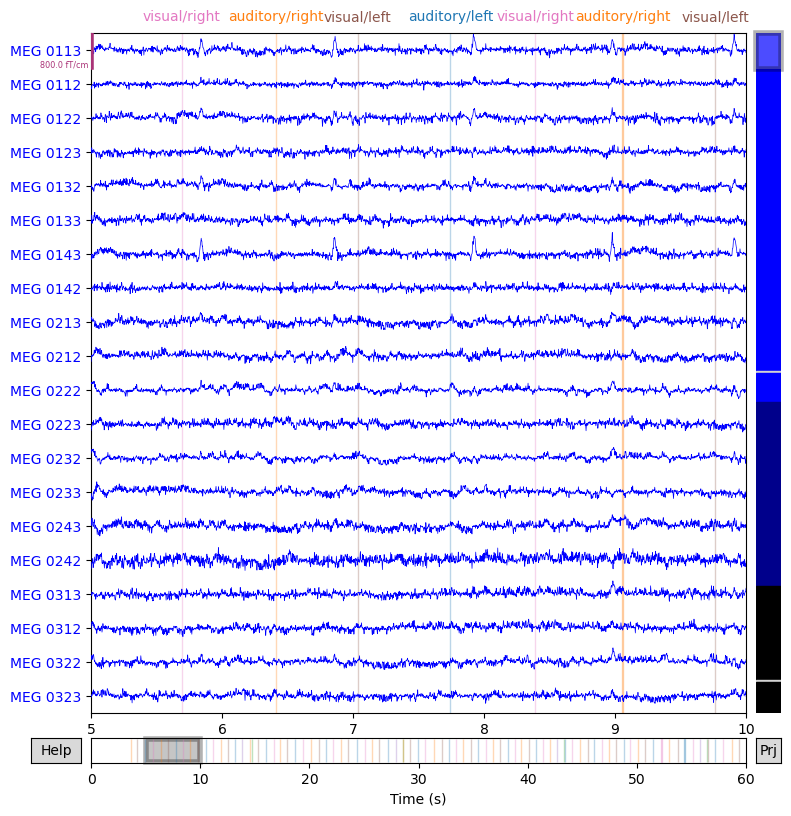

In [10]:
raw.plot(start = 5, duration = 5);

# multiple events per annotation

In [11]:
# create the REM annotations
rem_annot = mne.Annotations(onset=[5, 41],
                            duration=[16, 11],
                            description=['REM'] * 2)
raw.set_annotations(rem_annot)
(rem_events,
 rem_event_dict) = mne.events_from_annotations(raw, chunk_duration=1.5)

Used Annotations descriptions: ['REM']


In [12]:
print(np.round((rem_events[:, 0] - raw.first_samp) / raw.info['sfreq'], 3))

[ 5.     6.5    8.     9.5   11.    12.501 14.001 15.501 16.999 18.499
 41.    42.5   44.    45.5   47.    48.5   50.   ]
